In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14

# Neural Networks


## Activation functions



In [4]:
# the common activation functions:

def logistic(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

# and their derivatives:

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic_deriv(x):
    return logistic(x)*(1-logistic(x))

def relu_deriv(x) :
    deriv = x.copy()
    deriv[deriv < 0] = 0
    return deriv


<Figure size 900x400 with 0 Axes>

Text(0.5,1,'Activation functions')

[-5, 5, -1.2, 1.2]

Text(0.5,1,'Derivatives')

[-5, 5, -0.2, 1.2]

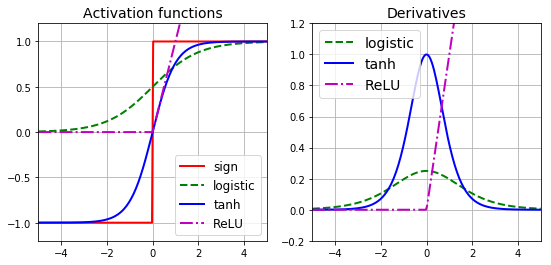

In [3]:
x = np.linspace(-5, 5, 200)
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(x, np.sign(x), "r-", linewidth=2, label="sign")
plt.plot(x, logistic(x), "g--", linewidth=2, label="logistic");
plt.plot(x, np.tanh(x), "b-", linewidth=2, label="tanh");
plt.plot(x, relu(x), "m-.", linewidth=2, label="ReLU");
plt.grid(True);
plt.legend(fontsize=12);
plt.title("Activation functions", fontsize=14);
plt.axis([-5, 5, -1.2, 1.2]);

plt.subplot(122)
plt.plot(x, logistic_deriv(x), "g--", linewidth=2, label="logistic")
plt.plot(x, tanh_deriv(x), "b-", linewidth=2, label="tanh")
plt.plot(x, relu_deriv(x), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.savefig('activation_functions.png')




## The XOR learning problem

The XOR problem is an example of data that is not linearly separable:

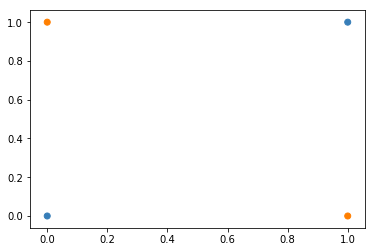

In [4]:
X = np.array( [[0,0], [0,1], [1,0], [1,1]])
y = np.array([0,1,1,0])
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], color=colors[y])

Let's demonstrate that this problem can be solved with a very simple neural network:

In [5]:
def mlp_xor(x1, x2, activation=tanh):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)


Text(0.5,1,'XOR network with tanh activation')

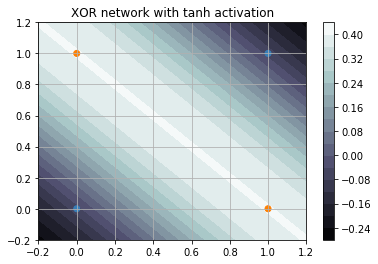

In [6]:
x1_values = np.linspace(-0.2, 1.2, 100)
x2_values = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1_values, x2_values)

z = mlp_xor(x1, x2, activation=tanh)

plot=plt.contourf(x1, x2, z, 20, cmap=plt.cm.bone)
plt.colorbar(plot)

plt.scatter(X[:, 0], X[:, 1], color=colors[y])
plt.title("XOR network with tanh activation", fontsize=12)
plt.grid(True)

You can also solve this problem with the ReLu activation fuction:

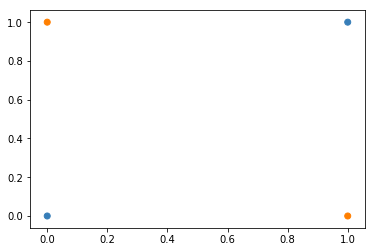

In [7]:

def relu(x):
    return np.maximum(x, 0)

w1 = np.ones((2,2))
b1 = np.array([0, -1])
w2 = np.array([1, -2])
b2 = 0

y_pred = relu(X.dot(w1) + b1).dot(w2) + b2

# plot the output generated by the network:
y_pred = np.array(y_pred, dtype='int')
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])


Let's look at the representation that was used to classify the data:

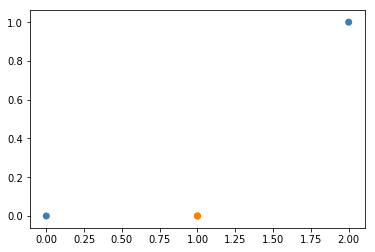

In [8]:
h = relu(X.dot(w1) + b1)
plt.scatter(h[:, 0], h[:, 1], color=colors[y])

In [25]:
class NeuralNetwork :
    def __init__(self, architecture, activation='logistic') :
        self.architecture = architecture
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_deriv
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        else :
            raise ValueError('Activation does not match options')
        self.initialize_weights()
        
    def initialize_weights(self) :
        W = {}
        b = {}
        for l in range(1, len(self.architecture)):
            W[l] = np.random.random((self.architecture[l], self.architecture[l-1]))
            b[l] = np.random.random((self.architecture[l],))
            #W[l] = np.random.randn(self.architecture[l], self.architecture[l-1])
            #b[l] = np.random.randn(self.architecture[l])
        self.W, self.b = W, b

    def forward(self, x):
        h = {1: x}
        s = {}
        for l in range(1, len(self.W) + 1):
            s[l+1] = self.W[l].dot(h[l]) + self.b[l]
            h[l+1] = self.activation(s[l+1])
        return h, s
        
    def init_delta_values(self):
        delta_W = {}
        delta_b = {}
        for l in range(1, len(self.architecture)):
            delta_W[l] = np.zeros((self.architecture[l], self.architecture[l-1]))
            delta_b[l] = np.zeros((self.architecture[l],))
        return delta_W, delta_b

    def calculate_output_layer_delta(self, y, h_out, s_out):
        return -(y-h_out) * self.activation_deriv(s_out)

    def calculate_hidden_delta(self, delta_plus_1, w_l, s_l):
        # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(s^(l))
        return np.dot(np.transpose(w_l), delta_plus_1) * self.activation_deriv(s_l)

    def fit(self, X, y, num_iterations=3000, alpha=0.25):
        iterations = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(num_iterations))
        while iterations < num_iterations :
            if iterations%100 == 0:
                print('Iteration {} of {}'.format(iterations, num_iterations))
                if len(avg_cost_func) > 0 :
                    print('cost: ', avg_cost_func[-1])
            delta_W, delta_b = self.init_delta_values()
            avg_cost = 0
            for i in range(len(y)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, s = self.forward(X[i, :])
                # backpropagate the errors
                for l in range(len(self.architecture), 0, -1):
                    if l == len(self.architecture):
                        delta[l] = self.calculate_output_layer_delta(y[i,:], h[l], s[l])
                        avg_cost += (np.linalg.norm((y[i,:]-h[l])) / N)
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], self.W[l], s[l])
                        delta_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                        delta_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(self.architecture) - 1, 0, -1):
                self.W[l] += -alpha * (1.0/N * delta_W[l])
                self.b[l] += -alpha * (1.0/N * delta_b[l])
            # complete the average cost calculation
            avg_cost_func.append(avg_cost)
            iterations += 1
        return avg_cost_func

    def predict(self, X):
        N = X.shape[0]
        y = np.zeros((N,))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            y[i] = np.argmax(h[len(self.architecture)])
        return y

    def decision_function(self, X):
        N = X.shape[0]
        scores = np.zeros((N,self.architecture[-1]))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            scores[i]=h[len(self.architecture)]
        return scores


In [22]:

architecture = [2, 3, 2]
network = NeuralNetwork(architecture)
X = np.random.randn(10, 2)
network.decision_function(X)


(10, 2)
(10, 2)


array([[ 0.83997171,  0.80862343],
       [ 0.77539435,  0.77146198],
       [ 0.7585131 ,  0.76352457],
       [ 0.77129192,  0.77047476],
       [ 0.73082053,  0.72970056],
       [ 0.79830232,  0.78025445],
       [ 0.80332407,  0.78607616],
       [ 0.86150465,  0.82762999],
       [ 0.80025889,  0.78521383],
       [ 0.78597356,  0.75506333]])

Let's apply the network to a digit recognition problem.  But before we do so, let's see how well we can do with an SVM...

//anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


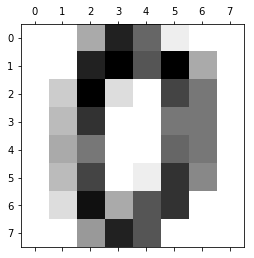

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.95331503132520745

In [10]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn import metrics

digits = load_digits()

plt.matshow(digits.images[0], cmap=plt.cm.gray_r)
plt.show()

digits = load_digits()
X_scale = StandardScaler()
#X = X_scale.fit_transform(digits.data)
X = digits.data / digits.data.max()
y = digits.target

from sklearn.model_selection import GridSearchCV
C_list = np.logspace(-2, 2, 10)
classifier = GridSearchCV(svm.SVC(kernel='linear'), dict(C=C_list), cv=5)
cv_results_nested = cross_validate(classifier, X, y, cv=5, scoring='accuracy')
np.mean(cv_results_nested['test_score'])


In [11]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

digits = load_digits()
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
#X = digits.data / digits.data.max()
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
# convert labels to vectors
y_vec_train = y_to_vect(y_train)
y_vec_test = y_to_vect(y_test)


Starting gradient descent for 4000 iterations
Iteration 0 of 4000
Iteration 100 of 4000
cost:  2.57537345395
Iteration 200 of 4000
cost:  2.18130487651
Iteration 300 of 4000
cost:  1.39322466988
Iteration 400 of 4000
cost:  0.91675175766
Iteration 500 of 4000
cost:  0.896294919991
Iteration 600 of 4000
cost:  0.875248649357
Iteration 700 of 4000
cost:  0.853556450919
Iteration 800 of 4000
cost:  0.831206649849
Iteration 900 of 4000
cost:  0.808409560832
Iteration 1000 of 4000
cost:  0.785314116242
Iteration 1100 of 4000
cost:  0.762069879728
Iteration 1200 of 4000
cost:  0.738954628916
Iteration 1300 of 4000
cost:  0.716239757337
Iteration 1400 of 4000
cost:  0.694048380588
Iteration 1500 of 4000
cost:  0.672417383751
Iteration 1600 of 4000
cost:  0.651396671924
Iteration 1700 of 4000
cost:  0.631071663657
Iteration 1800 of 4000
cost:  0.611523173857
Iteration 1900 of 4000
cost:  0.592791512152
Iteration 2000 of 4000
cost:  0.574934823047
Iteration 2100 of 4000
cost:  0.558021500537
It

Text(0,0.5,'Average loss')

Text(0.5,0,'Iteration number')

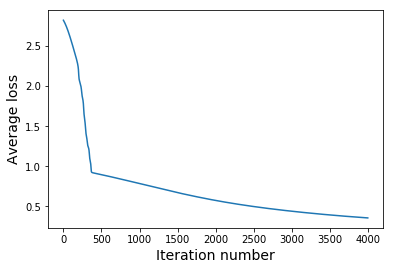

In [12]:
# the NN architecture
architecture = [64, 30, 10]
# train the NN
network = NeuralNetwork(architecture, 'logistic')
cost_func = network.fit(X_train, y_vec_train, 4000)
y_pred = network.predict(X_test)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

# plot the avg_cost_func
plt.plot(cost_func)
plt.ylabel('Average loss')
plt.xlabel('Iteration number')
